## Custom evaluate function for Multi-Objective Optimization - Transfer Matrix example
Version 1.0.0
(c) Vincent M. Le Corre, Larry Lueer, i-MEET 2021-2023

This notebook is made to use BOAR in combination with transfer matrix modeling (TMM) to optimize the thickness of the layers in a multilayer stack to optimize the average visible transmittance (AVT) and maximize the current density (Jsc) of a solar cell.  
To perform the transfer matrix modeling we use a modified version of the open-source program devoloped by [McGehee's group](https://web.stanford.edu/group/mcgehee/transfermatrix/) (Stanford University) and adapted to python by Kamil Mielczarek (University of Texas).  
For more information about the transfer matrix modeling, please refer to the [original paper](https://doi.org/10.1002/adma.201000883).  

Here, we show how to use the custom evaluate function for the optimization which allows to only run the TMM once per iteration and then evaluate the two objectives (AVT and Jsc) making the optimization faster.

In [1]:
# Activate matplotlib widgets
# %matplotlib inline
# comment the next line if you are on the jupyterhub server
# %matplotlib widget 
# %matplotlib notebook
import plotly.io as pio # comment out to only render png
pio.renderers.default = 'png'

# Import libraries
import sys,os,types
import warnings
warnings.filterwarnings('ignore') # comment this out to see warnings

# Import boar
sys.path.append('../') # comment out if the Notebook is in the Notebooks folder
from boar import *
from boar.core.optimization_botorch import *
# import additional libraries from Ax
from ax.utils.notebook.plotting import render, init_notebook_plotting # for plotting in notebook
from ax.plot.slice import plot_slice
from ax.plot.scatter import interact_fitted,plot_objective_vs_constraints,tile_fitted
from ax.modelbridge.cross_validation import cross_validate
from ax.plot.contour import interact_contour
from ax.plot.diagnostic import interact_cross_validation
from ax.plot.pareto_utils import compute_posterior_pareto_frontier
from ax.plot.pareto_frontier import plot_pareto_frontier
# Import homemade package by VLC
# import boar.SIMsalabim_utils.plot_settings_screen # to set default plot settings


In [2]:
# Define the path to the data 
curr_dir = os.getcwd() # current directory
res_dir = os.path.join(os.path.abspath('../'),'temp') # path to the results directory
mat_dir = os.path.join(os.path.abspath('../'),'Example_Data/matdata') # path to the mat files directory, comment if not in Notebooks folder

In [3]:
# Initialize the agent and default device stack
layers 			= ['SiOx' , 'ITO' , 'ZnO' , 'PCE10_FOIC_1to1' , 'MoOx' , 'Ag', 'MoOx', 'LiF','MoOx', 'LiF','Air'] # list of layers (need to be the same than the name nk_*.csv file in the matdata folder)
thicknesses		= [0 , 100 , 30  , 100 , 9 , 8, 100, 100, 100, 100, 100] # list of thicknesses in nm
        
tm = Transfer_Matrix_agent(layers=layers, thicknesses=thicknesses,mat_dir=mat_dir) # initialize the agent

# Define the free parameters to be optimized

In this notebook, we not only optimize the thickness of the different layers in the stack, but also the material composition of the absorber layer by optimizing the nk values selected by the parameter nk_3.  
This can be done by passing a list of names of the materials to the parameter nk_3 in the lims attribute and by choosing the value_type of the FitParam object as 'str'. We also limit the resolution of the thickness to 1 nm by optimizing the thicknesses values as integers (value_type='int').

In [4]:
params = []
d_3 = Fitparam(name = 'd_3', val =  80, lims = [40, 200], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'AL thickness', unit = 'nm',val_type='int')
params.append(d_3)
d_4 = Fitparam(name = 'd_4', val =  100, lims = [0, 200], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'MoOx 1 thickness', unit = 'nm',val_type='int')
params.append(d_4)
d_5 = Fitparam(name = 'd_5', val =  10, lims = [0, 15], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'Ag thickness', unit = 'nm',val_type='int')
params.append(d_5)
d_6 = Fitparam(name = 'd_6', val =  100, lims = [0, 200], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'MoOx 2 thickness', unit = 'nm',val_type='int')
params.append(d_6)
d_7 = Fitparam(name = 'd_7', val =  10, lims = [0, 200], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'LiF 1 thickness', unit = 'nm',val_type='int')
params.append(d_7)  
d_8 = Fitparam(name = 'd_8', val =  100, lims = [0, 200], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'MoOx 3 thickness', unit = 'nm',val_type='int')
params.append(d_8)
d_9 = Fitparam(name = 'd_9', val =  10, lims = [0, 200], relRange = 0, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'LiF 2 thickness', unit = 'nm',val_type='int')
params.append(d_9)
nk_3 = Fitparam(name = 'nk_3', val =  'PCE10_FOIC_1to1', lims = ['PCE10_FOIC_1to1','P3HTPCBM_BHJ','PM6Y6Brabec'], relRange = 0.5, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'AL nk', unit = '',val_type='str')
params.append(nk_3)

In [5]:
# run the model on the default stack configuration
X = [0] # we need to provide a list of inputs even if it is not used later

print('Jsc = ', tm.TM(X,params,output=['Jsc'],is_MOO=False))
print('LUE = ', tm.TM(X,params,output=['LUE'],is_MOO=False))
print('AVT = ', tm.TM(X,params,output=['AVT'],is_MOO=False))

Jsc =  10.53248308747983
LUE =  3.5542800166757664
AVT =  0.337458886679895


# Start the optimization

Here, we use the custom evaluation function since both targets are outputted by the same model. This allows us to call the model only once per sample and saves calculation time.

In [6]:
# We create a new class that inherits from the MooBOtorch class, this is necessary to be able to write a custom evaluation function that can be ran in parallel
class customMooBOtorch(MooBOtorch):
    def __init__(self,params = None, targets = None, parameter_constraints = None, warmstart = None, Path2OldXY = None, SaveOldXY2file = None, res_dir = 'temp', use_evaluate_custom = None, parallel = True, verbose = False) -> None:
        """Initialization routine

        Parameters
        ----------
        targets : list of dict, optional
            List of Dictionaries with the following keys:\\
                'model': a pointer to a function y = f(X) where X has m dimensions\\
                'data': dictionary with keys\\
                'X':ndarray with shape (n,m) where n is the number of evaluations for X \\
                'y':ndarray with shape (n,)\\
                'X_dimensions': list of string: the names of the dimensions in X\\
                'X_units': list of string: the units of the dimensions in X\\
                'y_dimension': string: the name of the dimension y\\
                'y_unit': string: the unit of the dimension y\\
                'params': list of Fitparam() objects, by default None\\
        warmstart : str, optional
                'None', 'collect', 'collect_init', 'collect_BO', 'recall' or 'collect&recall', by default None\\
                    if 'None' does not store results\\
                    if 'collect' stores all results\\
                    if 'collect_init' stores results from the initial sampling only. NOTE: In reality it collects the n_jobs*(n_initial_points + n_BO)/n_initial_points first point, so you may get some of the first few BO points depending on n_jobs\\
                    if collect_BO' stores results from the Bayesian Optimization only\\
                    if 'recall' recalls results\\
                    if 'collect&recall' stores and recalls results\\
        Path2OldXY : str, optional
            full path to the json file containing the self.old_xy results to be loaded, by default None
        SaveOldXY2file : str, optional
            full path to the json file where the new self.old_xy results will be saved if it is None then we do not save the data, by default None
        res_dir : str, optional
            directory where the results will be saved, by default 'temp'
        evaluate_custom : function, optional
            use a custom evaluation function instead of the default one, this is useful when the same model is used for different targets, by default None
        parallel : bool, optional
            use parallelization, if False n_jobs can still be > 1 but the evaluation will be done sequentially, by default True
        verbose : bool, optional
            print some information, by default False

        """        
        if targets != None:
            self.targets = targets
        
        if params != None:
            self.params = params
        
        if parameter_constraints != None:
            self.parameter_constraints = parameter_constraints
        else:
            self.parameter_constraints = None
        
        self.warmstart = warmstart # want to re-use expensive calculations from a previous run?
        if self.warmstart == None:
            self.warmstart = 'None'
        
        self.old_xy = {'ydyn':1,'x':[],'y':[]} # dict to hold the calculations from a previous run if warmstart==True
        self.Path2OldXY = Path2OldXY
        self.SaveOldXY2file = SaveOldXY2file # path to file where we want to save the old_xy data
        self.verbose = verbose
        self.res_dir = res_dir
        if not os.path.exists(self.res_dir):
            os.makedirs(self.res_dir)
        self.cwd = os.getcwd()

        self.use_evaluate_custom = use_evaluate_custom
        self.parallel = parallel

    def evaluate_custom(self,px,obj_type,loss,threshold=1,is_MOO=True):
        """Custom evaluation function that can be used instead of the default one

        Parameters
        ----------
        px : list
            list of parameters values
        obj_type : str
            type of objective function to be used, see self.obj_func_metric
        loss : str
            loss function to be used, see self.lossfunc
        threshold : float, optional
            threshold for the loss function, by default 1
        is_MOO : bool, optional
            whether to use multi-objective optimization or enforce single-objective optimization, by default False

        Returns
        -------
        dict
            dictionary with the results, the keys are the names of the targets
        """        

        pnames = [p.name for p in self.params if p.relRange != 0]
        target_names = [t['target_name'] for t in self.targets]

        px_ = [px[pnames[i]] for i in range(len(pnames))]

        self.params_w(px_,self.params)

        model = self.targets[0]['model']

        X = self.targets[0]['data']['X']

        res_dum = model(X,self.params) # evaluate the model only once

        res = {}
        for t in self.targets:
            dum = res_dum[t['target_name']]
            if 'obj_type' in t.keys():
                obj_dum = t['obj_type']
            else:
                obj_dum = obj_type
            if 'loss' in t.keys():
                loss_dum = t['loss']
            else:
                loss_dum = loss
            
            z = self.obj_func_metric(t,dum,obj_type=obj_dum)
            res[obj_dum+'_'+t['target_name']] = self.lossfunc(z,loss_dum,threshold=1) # threshold is set to 1 as we don't need it for MOO and if it is a list it will not work

        return res


In [7]:
# Define the targets and the model for the TM problem
X_dimensions = ['_']
y_dimension = 'J'
target = {'model':partial(tm.TM,output=['Jsc'],is_MOO=True),'target_name':'Jsc','minimize':False,
          'data':{'X':X,'y':[0],'X_dimensions':X_dimensions,'X_units':['s',''],'y_dimension':y_dimension,'y_unit':''}
            ,'target_weight':1, 'weight':1}

y_dimension = 'AVT'
target2 = {'model':partial(tm.TM,output=['AVT'],is_MOO=True),'target_name':'AVT','minimize':True,'obj_type':'diff',
          'data':{'X':X,'y':[0.4],'X_dimensions':X_dimensions,'X_units':['s',''],'y_dimension':y_dimension,'y_unit':''}
            ,'target_weight':1, 'weight':1}

targets = [target,target2]
obj_type='identity'
loss='linear'
threshold=[10,0.05]

mo = customMooBOtorch(params=params, targets= targets,parallel=True) # initialize the custom optimization object

ax_client = mo.BoTorchOpti(n_jobs=[80,4], n_step_points = [80, 80], models=['Sobol','MOO'],obj_type=obj_type,loss=loss,threshold=threshold,use_CUDA=True,is_MOO=True,verbose=True,show_posterior=False,kwargs_posterior={},use_custom_func=True)

[INFO 01-18 09:15:56] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 01-18 09:15:56] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='d_3', parameter_type=INT, range=[40, 200]), RangeParameter(name='d_4', parameter_type=INT, range=[0, 200]), RangeParameter(name='d_5', parameter_type=INT, range=[0, 15]), RangeParameter(name='d_6', parameter_type=INT, range=[0, 200]), RangeParameter(name='d_7', parameter_type=INT, range=[0, 200]), RangeParameter(name='d_8', parameter_type=INT, range=[0, 200]), ChoiceParameter(name='nk_3', parameter_type=STRING, values=['PCE10_FOIC_1to1', 'P3HTPCBM_BHJ', 'PM6Y6Brabec'], is_ordered=False, sort_values=False)], parameter_constraints=[]).
[INFO 01-18 09:15:56] ax.service.ax_client: Generated new trial 0 with parameters {'d_3': 166, 'd_4': 117, 'd_5': 7,

In [8]:
# Print the optimized stack structure
for p in mo.params:
    if p.val_type != 'str':
        print(p.display_name + f' {p.val:.0f} nm')
    else:
        print(p.display_name + f' {p.val}')

# Optimized performance
print('Jsc = ', tm.TM(X,params,output=['Jsc'],is_MOO=False))
print('LUE = ', tm.TM(X,params,output=['LUE'],is_MOO=False))
print('AVT = ', tm.TM(X,params,output=['AVT'],is_MOO=False))

AL thickness 132 nm
MoOx 1 thickness 173 nm
Ag thickness 5 nm
MoOx 2 thickness 136 nm
LiF 1 thickness 134 nm
MoOx 3 thickness 105 nm
LiF 2 thickness 10 nm
AL nk PCE10_FOIC_1to1
Jsc =  16.60698379218779
LUE =  6.298753248997721
AVT =  0.3792833983471919


In [9]:
# get all tried data from the ax_client
triedX = ax_client.generation_strategy.trials_as_df
print(triedX.tail())
triedY = ax_client.experiment.fetch_data().df
print(triedY.tail())

[INFO 01-18 09:26:05] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


     Generation Step Generation Model  Trial Index Trial Status  \
155                1              MOO          155    COMPLETED   
156                1              MOO          156    COMPLETED   
157                1              MOO          157    COMPLETED   
158                1              MOO          158    COMPLETED   
159                1              MOO          159    COMPLETED   

                                 Arm Parameterizations  
155  {'155_0': {'d_3': 124, 'd_4': 186, 'd_5': 4, '...  
156  {'156_0': {'d_3': 121, 'd_4': 188, 'd_5': 4, '...  
157  {'157_0': {'d_3': 124, 'd_4': 177, 'd_5': 4, '...  
158  {'158_0': {'d_3': 124, 'd_4': 178, 'd_5': 4, '...  
159  {'159_0': {'d_3': 124, 'd_4': 178, 'd_5': 4, '...  
    arm_name   metric_name       mean  sem  trial_index
315    157_0      diff_AVT   0.000258  NaN          157
316    158_0  identity_Jsc  16.037003  NaN          158
317    158_0      diff_AVT   0.000975  NaN          158
318    159_0  identity_Jsc  16.

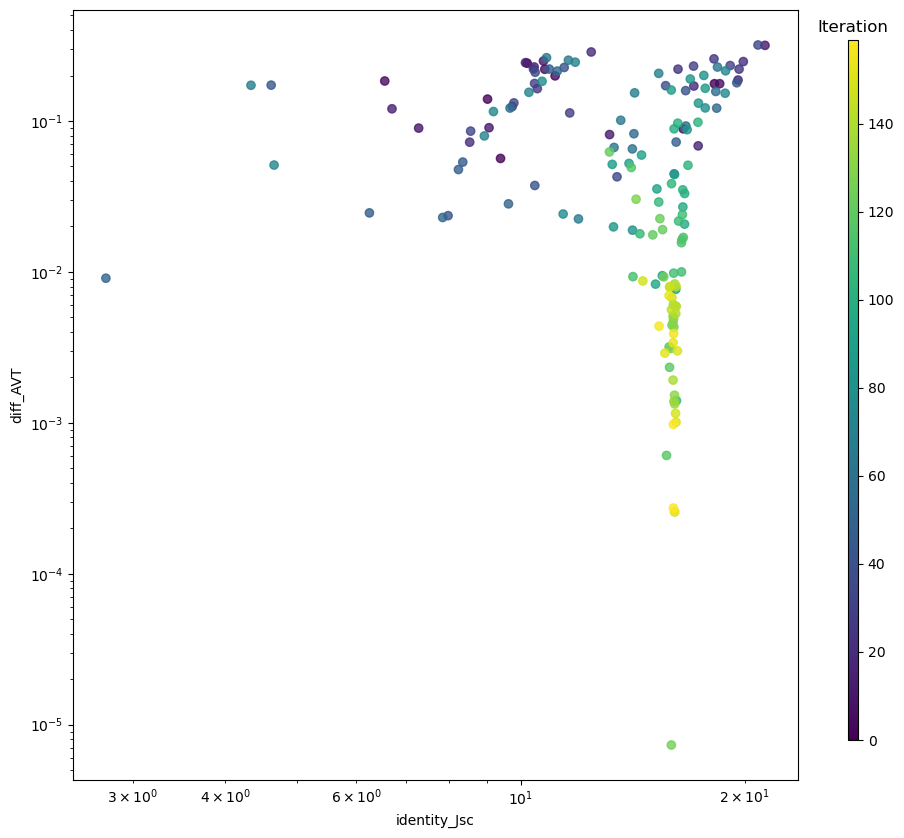

In [10]:
# Plot the Pareto front of the test problem
mo.plot_all_objectives(ax_client,logscale=True,figsize=(10,10))

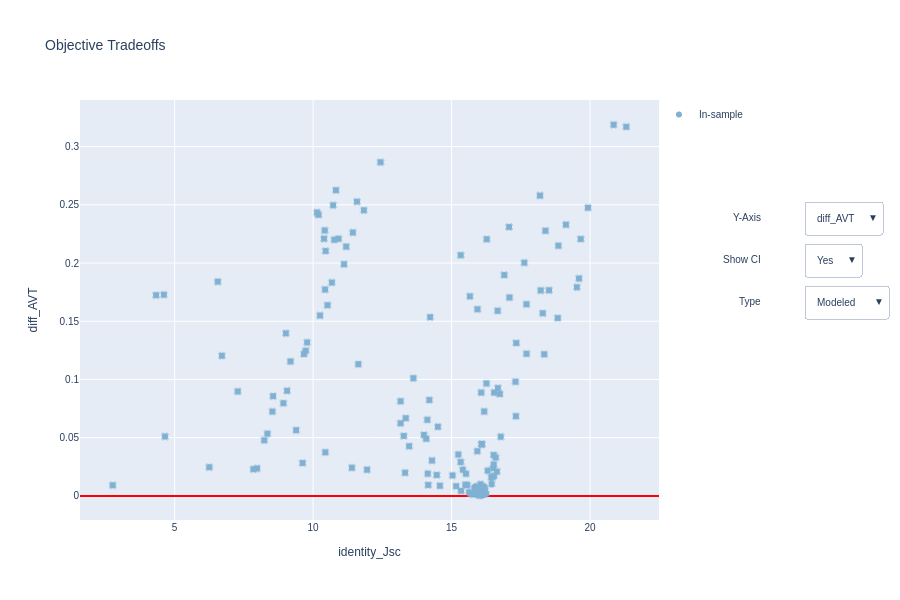

In [11]:
# Interactive plotting of the objective function tradeoffs
model = ax_client.generation_strategy.model
render(plot_objective_vs_constraints(model, 'identity_Jsc', rel=False))

[INFO 01-18 09:26:08] ax.service.ax_client: Retrieving contour plot with parameter 'd_3' on X-axis and 'd_4' on Y-axis, for metric 'identity_Jsc'. Remaining parameters are affixed to the middle of their range.


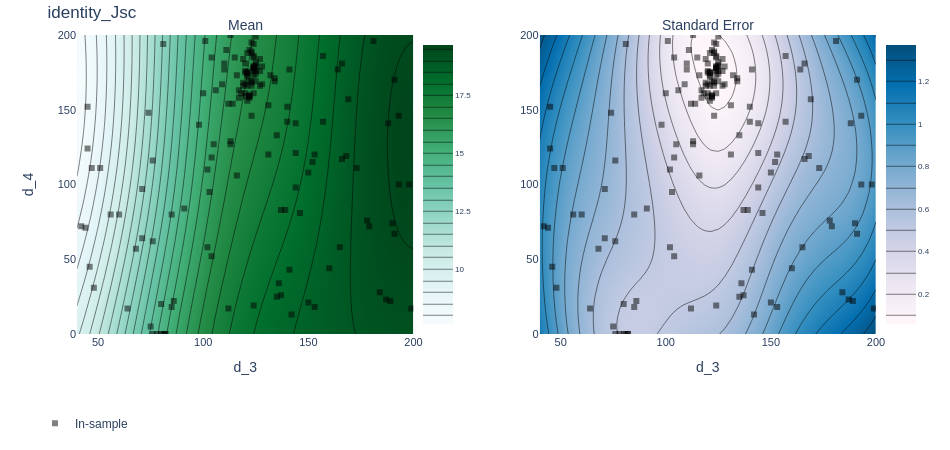

[INFO 01-18 09:26:10] ax.service.ax_client: Retrieving contour plot with parameter 'd_3' on X-axis and 'd_4' on Y-axis, for metric 'diff_AVT'. Remaining parameters are affixed to the middle of their range.


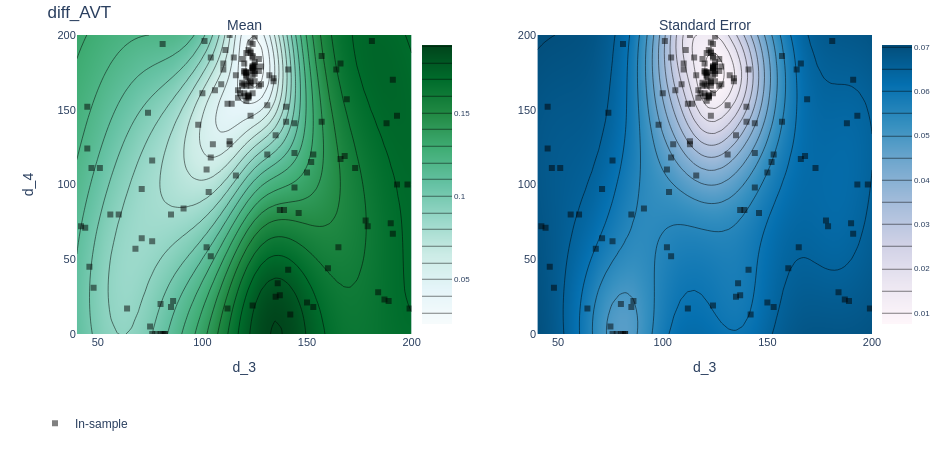

In [12]:
# Plot the contour of the objective function for a given target
render(ax_client.get_contour_plot(param_x="d_3", param_y="d_4", metric_name=obj_type+'_'+target['target_name']))
render(ax_client.get_contour_plot(param_x="d_3", param_y="d_4", metric_name=target2['obj_type']+'_'+target2['target_name']))

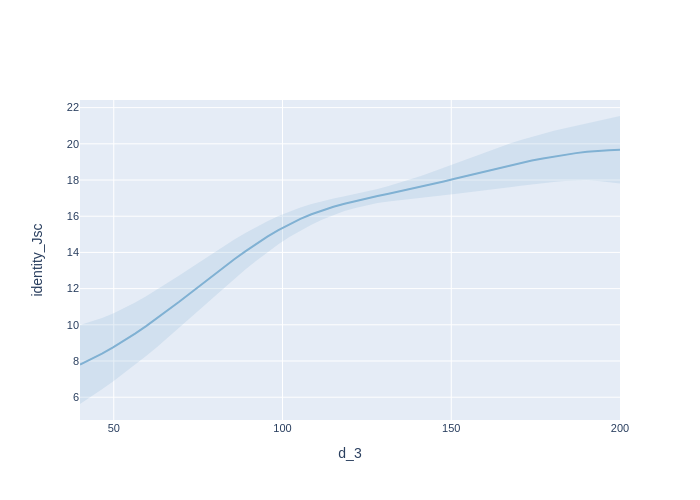

In [13]:
# Plot the slice (i.e., 1D projection) of the model along the a single dimension 
render(plot_slice(model, "d_3", obj_type+'_'+target['target_name']))

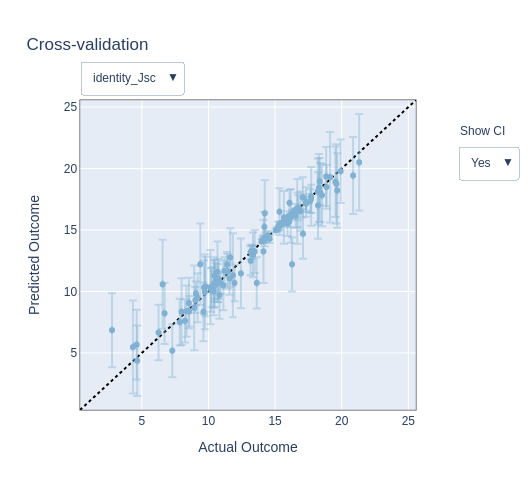

In [14]:
# Plot the results of cross validation
cv_results = cross_validate(model)
render(interact_cross_validation(cv_results))

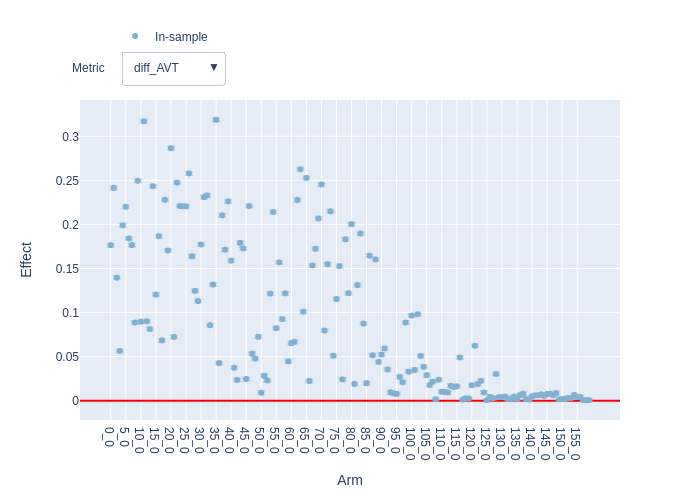

In [15]:
# Interactive plot of the target during the optimization process
render(interact_fitted(model, rel=False))

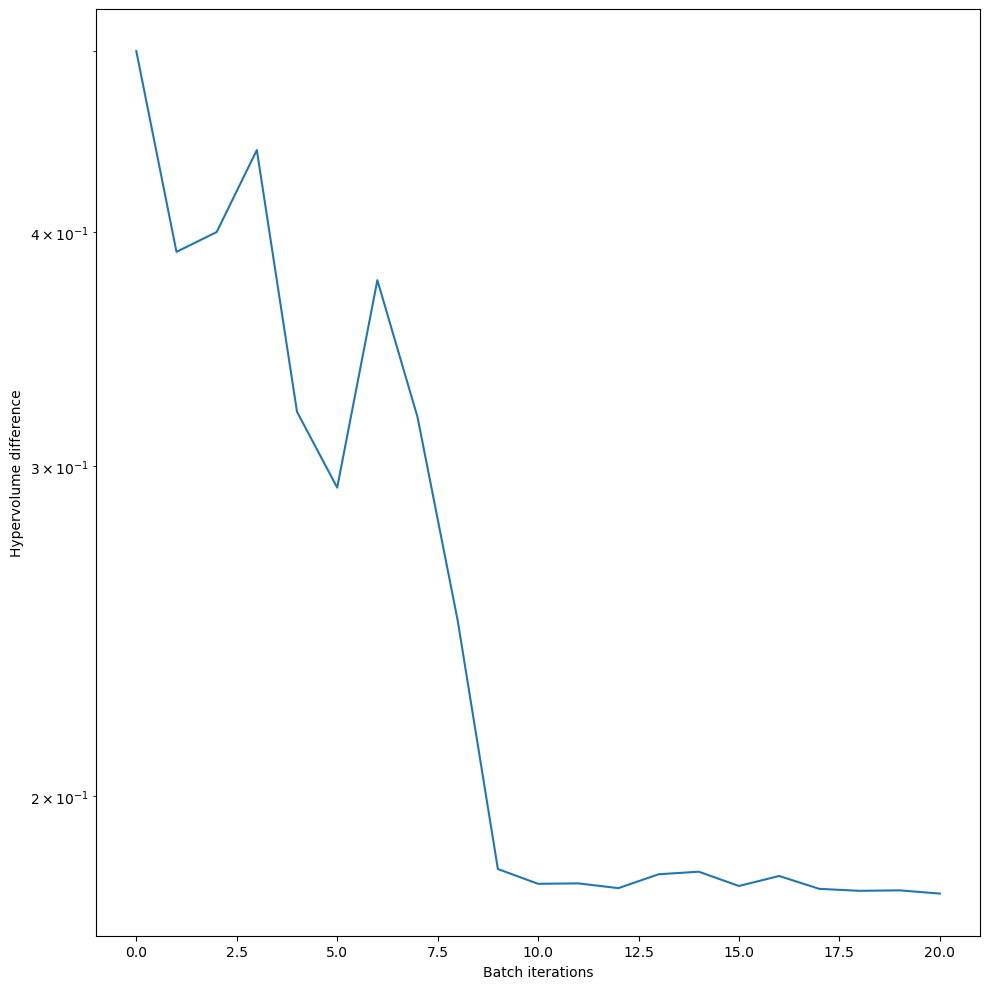

In [16]:
# Plot the hypervolume evolution during the optimization
mo.plot_hypervolume(logscale=True,figsize=(10,10))

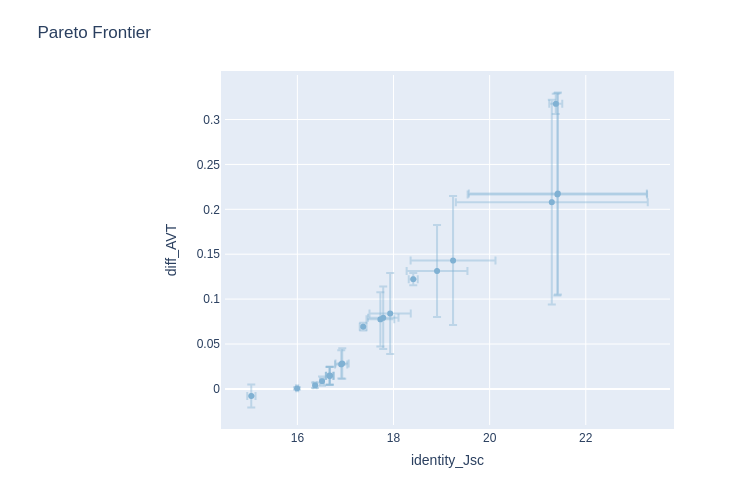

In [17]:
# Compute and plot the Pareto frontier
objectives = ax_client.experiment.optimization_config.objective.objectives
frontier = compute_posterior_pareto_frontier(
    experiment=ax_client.experiment,
    data=ax_client.experiment.fetch_data(),
    primary_objective=objectives[1].metric,
    secondary_objective=objectives[0].metric,
    absolute_metrics=["diff_AVT", "identity_Jsc"],
    num_points=20,
)
render(plot_pareto_frontier(frontier, CI_level=0.90)) 